# Task Relevant Concepts, the Instruction feature and Adversarial Prompts for MemoryDT

## Set Up 

In [421]:
import sys 
import torch
import numpy as np
import plotly.express as px

sys.path.append("..")

from src.streamlit_app.environment import get_env_and_dt
from src.environments.registration import register_envs
from src.environments.memory import MemoryEnv
from src.decision_transformer.offline_dataset import one_hot_encode_observation
from src.streamlit_app.causal_analysis_components import get_updated_obs

register_envs()

def get_all_memory_env_scenarios(env, rtg=0.8920):

    env.reset()

    all_observations = []
    all_actions = []

    for target_obj in ["key", "ball"]:
        for target_pos in ["top", "bottom"]:
            scenario = f"{target_obj}_{target_pos}"
            observations = [] 
            actions= []

            # generate the new environment 
            env._gen_grid(7,7,target_obj=target_obj, target_pos=target_pos)
            obs = env.gen_obs()['image']
            observations.append(obs)
            for _ in range(4):
                action = 2
                next_obs, reward, next_done, next_truncated, info  = env.step(action)
                observations.append(next_obs['image'])
                actions.append(action)

            all_observations.append(observations)
            all_actions.append(actions)

            

    all_observations = torch.from_numpy(np.stack(all_observations))
    all_actions = torch.from_numpy(np.stack(all_actions))

    one_hot_s = torch.stack([one_hot_encode_observation(all_observations[i]) for i in range(all_observations.shape[0])])

    # pad the first dimension to be 9 with all 0's 
    obs = torch.cat([
        torch.zeros(one_hot_s.shape[0], 9 - one_hot_s.shape[1], *one_hot_s.shape[2:]), 
        one_hot_s
        ], dim=1)
    obs.shape

    actions = torch.stack([all_actions[i] for i in range(all_actions.shape[0])])
    # pad it with 7's so that the length is 9 
    actions = torch.cat([
        torch.ones(actions.shape[0], 8 - actions.shape[1]) * 7, 
        actions
        ], dim=1).to(int).unsqueeze(-1)
    actions.shape

    time = torch.cat([
        torch.tensor([0]*5),
        torch.arange(1,5),
        ], dim=0)
    # repeat it for each trajectory
    time = torch.stack([time] * actions.shape[0]).unsqueeze(-1)

    # just set to max for now 
    rtg = torch.ones(actions.shape[0], time.shape[1]).unsqueeze(-1) * rtg

    scenario_labels = [
        'Key, Key-Ball',
        'Key, Ball-Key',
        'Ball, Ball-Key',
        'Ball, Key-Ball'
    ]

    return obs, actions, rtg, time, scenario_labels

from src.visualization import render_minigrid_observations, render_minigrid_observation
from src.environments.utils import reverse_one_hot
import PIL
import io
from IPython.display import Image

def get_images_batched(env, obs):
    all_images = []
    for scenario in range(obs.shape[0]):
        original_obs = np.stack([reverse_one_hot(obs[scenario][i]) for i in range(obs.shape[1])])
        images = render_minigrid_observations(env, original_obs)
        all_images.append(images)

    all_images = torch.from_numpy(np.stack(all_images))
    return all_images

def get_trajectory_plotly_animation(all_images, 
    scenario_labels = [
        ['Key, Key-Ball',
         'Key, Ball-Key',
         'Ball, Ball-Key',
         'Ball, Key-Ball',]
    ]):

    # show all trajectories with animation frame. 
    fig = px.imshow(all_images[:,4:], animation_frame=1, facet_col=0)
    # add 0 - 6 as xticks mdoe linear
    labels = [str(i) for i in list(range(0,7))]

 
    # compute tick positions assuming the width of the plot is normalized to 1
    tick_positions =  np.linspace(0,224,8)[1:] - 16

    # add xticks
    fig.update_xaxes(
        tickmode = 'array',
        tickvals = tick_positions,
        ticktext = labels
    )

        # add xticks
    fig.update_yaxes(
        tickmode = 'array',
        tickvals = tick_positions,
        ticktext = labels
    )

    # update facet col names with scenario labels
    fig.for_each_annotation(lambda a: a.update(text=scenario_labels[0][int(a.text.split("=")[-1])]))
    # increase font size
    fig.update_layout(font=dict(size=24))
    # make it much larger
    fig.update_layout(width=1200)
    return fig 

def create_animation(fig, file_name="test.gif", 
                     additional_frames_start=0,
                     additional_frames_end=5, 
                     duration=500, loop=0):
    """
    Creates an animated GIF from a Plotly figure with frames.

    Parameters:
    - fig: The Plotly figure object containing the frames for the animation.
    - file_name (str): The name of the output GIF file.
    - additional_frames_start (int): The number of additional frames to add at the start of the GIF.
    - additional_frames_end (int): The number of additional frames to add at the end of the GIF.
    - duration (int): The duration of each frame in the GIF in milliseconds.
    - loop (int): The number of times to loop the GIF. 0 for infinite looping.

    Returns:
    None
    """
    frames = []



    for s, fr in enumerate(fig.frames):
        # set main traces to appropriate traces within plotly frame
        fig.update(data=fr.data)
        # move slider to correct place
        fig.layout.sliders[0].update(active=s)
        # hide controls
        fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 0
        # hide play button
        fig.layout.updatemenus[0].buttons[1].args[1]["frame"]["duration"] = 0
        # generate image of current state
        frames.append(PIL.Image.open(io.BytesIO(fig.to_image(format="png"))))

    # append duplicated first image more times, to keep animation stop at first status
    for i in range(additional_frames_start):
        frames.insert(0, frames[0])

    # append duplicated last image more times, to keep animation stop at last status
    for i in range(additional_frames_end):
        frames.append(frames[-1])

    # create animated GIF
    frames[0].save(
        file_name,
        save_all=True,
        append_images=frames[1:],
        optimize=False,
        duration=duration,
        loop=loop,
    )

def update_observations(obs, frame_to_update, positions, channels):
    # create a copy of obs to avoid editing it 
    obs = obs.clone()
    for scenario in range(obs.shape[0]):
        channel = channels[scenario]

        for position in positions:
            obs[scenario][frame_to_update] = get_updated_obs(
                obs[scenario], frame_to_update, position[0], position[1], channel
            )

    return obs

In [438]:
# GET MODEL AND ENVIRONMENT
model_index = {
    # The original post, reproduced with 1/10th of the total training epochs
    "models/MiniGrid-MemoryS7FixedStart-v0/WorkingModel.pt": "MemoryDT",
    "models/MiniGrid-MemoryS7FixedStart-v0/MemoryGatedMLP.pt": "MemoryDTGatedMLP",
    "models/MiniGrid-Dynamic-Obstacles-8x8-v0/ReproduceOriginalPostShort.pt": "DynamicObstaclesDT_reproduction",
}

env, dt = get_env_and_dt("../models/MiniGrid-MemoryS7FixedStart-v0/WorkingModel.pt")
_, dt_gated_mlp = get_env_and_dt("../models/MiniGrid-MemoryS7FixedStart-v0/MemoryGatedMLP.pt")

# Convert these synthetic trajectories into what we need for the model
env = MemoryEnv(
    size=7, 
    random_direction=False, 
    random_start_pos=False, 
    random_length=False, 
    render_mode="rgb_array")

# get all scenarios
obs, actions, rtg, time, scenario_labels = get_all_memory_env_scenarios(env, rtg=0.0)

# convert to tokens 
tokens = dt.to_tokens(obs, actions, rtg, time)

# run transfomer
x, cache = dt.transformer.run_with_cache(tokens, remove_batch_dim=False)

# get preds
state_preds, action_preds, reward_preds = dt.get_logits(
    x, batch_size=4, seq_length=9, no_actions=False,  # we always pad now.
) # internal method that sometimes gets different args so we need to know them .


Ignore T-Lens warnings about folding layer norm into unembed, we just did it manually
Ignore T-Lens warnings about folding layer norm into unembed, we just did it manually


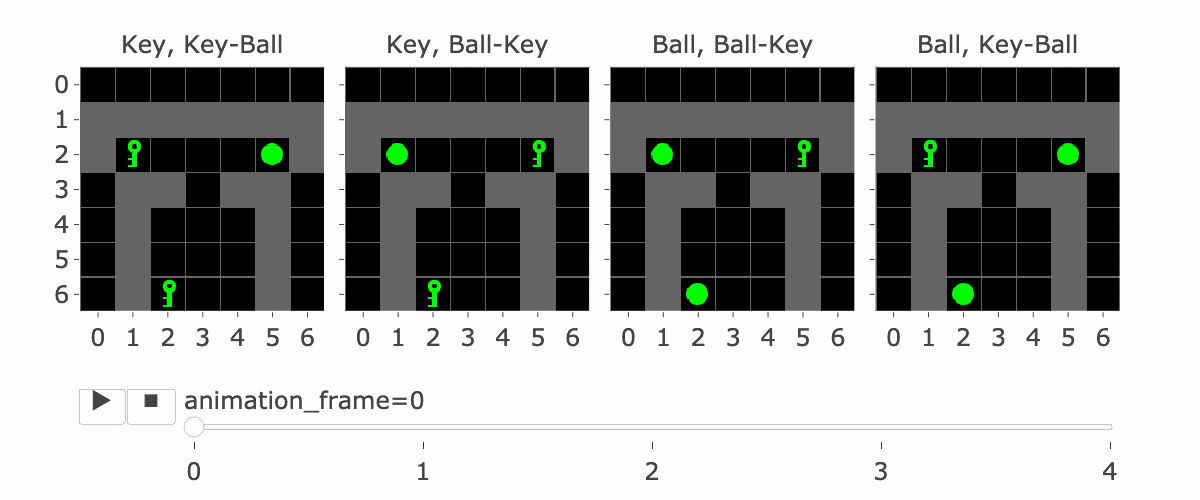

In [423]:
all_images = get_images_batched(env, obs)
fig = get_trajectory_plotly_animation(all_images)

fig.show()
# make animation
create_animation(fig, file_name="scenario_1_test.gif", additional_frames_start=1, duration=300, loop=0)
Image(filename="scenario_1_test.gif") # render in notebook

## Creating Eval Trajectories 

In order to understand the models behavior better, we can prompt it with scenarios where it's observations are slightly different. This is not limited to the set of possible scenarios according to the game rules. 

There are two major categories of the kinds of observations we are generating:
1. Flipping objects. Here we change things like what the instruction was at the start of the trajectory or the top target item. 
2. Adding objects. Here we add objects that wouldn't be present in a normal run of the model. 

In [363]:
#  Example usage of the "update_observations" function. 
frame_to_update = 4
positions = [(4, 2)]
channels = [6,6,5,5] # 6 is ball, 5 is key. # We edit all four base scenarios at once.

new_obs = update_observations(obs, frame_to_update, positions, channels)
updated_images = get_images_batched(env, new_obs)
fig = get_trajectory_plotly_animation(updated_images)
fig.show()


## Library of Scenarios

1. Original

Flipping instructions/targets

- Flipped instruction S5
- Flipped targets S5
- Flipped targets S9
- Flipped targets S5 and S9

Adding Objects/Adversarial

- Adding Instruction Complement at 0,5 in S5
- Adding Instruction Complement at 4,2 in S5
- Adding Instruction Complement at 4,2 and 0,5 in S5
- Adding Instruction Complement at 0,5 in S9
- Adding Instruction Complement at 4,2 in S9
- Adding Instruction Complement at 4,2 and 0,5 in S9

In [376]:
# Herefollows a library of alternative scenarios. 

original_obs = obs.clone()


## Flipped Observations

# flipped instruction
instruction_complement_26_S5 = update_observations(
    original_obs, 
    frame_to_update=4, 
    positions = [(2, 6)],
    channels = [6,6,5,5]
)

# flipped targets S5 (half)
flipped_targets_half_start = update_observations(
    original_obs, 
    frame_to_update=4, 
    positions = [(1,2)],
    channels = [6,5,5,6]
)

# flipped targets S5 (full)
target_complement_S5 = update_observations(
    flipped_targets_half_start.clone(), 
    frame_to_update=4, 
    positions = [(5,2)],
    channels = [5,6,6,5]
)

# flipped targets S9 (half)
flipped_targets_half_end = update_observations(
    original_obs, 
    frame_to_update=8, 
    positions = [(1,6)],
    channels = [6,5,5,6]
)

# flipped targets S9 (full)
target_complement_S9 = update_observations(
    flipped_targets_half_end, 
    frame_to_update=8, 
    positions = [(5,6)],
    channels = [5,6,6,5]
)

# flipped targets at S5 and S9 (half)
flipped_targets_half_start_and_end = update_observations(
    target_complement_S5, 
    frame_to_update=8, 
    positions = [(1,6)],
    channels = [6,5,5,6]
)

# flipped targets at S5 and S9 (full)
target_complement_S5_S9 = update_observations(
    flipped_targets_half_start_and_end, 
    frame_to_update=8, 
    positions = [(5,6)],
    channels = [5,6,6,5]
)

##  Adversarial

# Adding Instruction Complement at (0,5) in S5
instruction_complement_05_S5 = update_observations(
    original_obs, 
    frame_to_update=4, 
    positions = [(0, 5)],
    channels = [6,6,5,5]
)

# Adding Instruction Complement at (4,2) in S5
instruction_complement_42_S5 = update_observations(
    original_obs, 
    frame_to_update=4, 
    positions = [(4,2)],
    channels = [6,6,5,5]
)

# Adding Instruction Complement at (0,5), (4,2) in S5
instruction_complement_05_42_S5 = update_observations(
    original_obs, 
    frame_to_update=4, 
    positions = [(0,5),(4,2)],
    channels = [6,6,5,5]
)

# Adding Instruction Complement at (0,5) in S9
instruction_complement_05_S9 = update_observations(
    original_obs, 
    frame_to_update=8, 
    positions = [(0, 5)],
    channels = [6,6,5,5]
)

# Adding Instruction Complement at (4,2) in S9
instruction_complement_42_S9 = update_observations(
    original_obs, 
    frame_to_update=8, 
    positions = [(4,2)],
    channels = [6,6,5,5]
)

# Adding Instruction Complement at (0,5), (4,2) in S9
instruction_complement_05_42_S9 = update_observations(
    original_obs, 
    frame_to_update=8, 
    positions = [(0,5),(4,2)],
    channels = [6,6,5,5]
)

# create a dictionary of all the scenarios

scenario_dict = {
    "original": original_obs,
    "0_instruction_complement_26_S5": instruction_complement_26_S5,
    # S5
    "1_instruction_complement_05_S5": instruction_complement_05_S5,
    "2_instruction_complement_42_S5": instruction_complement_42_S5,
    "3_instruction_complement_05_42_S5": instruction_complement_05_42_S5,
    # S9
    "instruction_complement_05_S9": instruction_complement_05_S9,
    "instruction_complement_42_S9": instruction_complement_42_S9,
    "instruction_complement_05_42_S9": instruction_complement_05_42_S9,

    # Target changes
    "target_complement_S5": target_complement_S5,
    "target_complement_S9": target_complement_S9,
    "flipped_targets_full_start_and_end": target_complement_S5_S9,
}

In [428]:
all_obs = torch.cat([scenario_dict[scenario].clone() for scenario in scenario_dict.keys()], dim=0)
updated_images = get_images_batched(env, all_obs)
updated_images.shape

.shape

torch.Size([4, 9, 224, 224, 3])

In [437]:

fig = px.imshow(updated_images[:20:4,4],facet_col=0)
# add 0 - 6 as xticks mdoe linear
labels = [str(i) for i in list(range(0,7))]

facet_labels = [
    "Original",
    "Instruction Flipped",
    "Complement (0,5)",
    "Complement (4,2)",
    "Complement (0,5), (4,2)",
]
# compute tick positions assuming the width of the plot is normalized to 1
tick_positions =  np.linspace(0,224,8)[1:] - 16
# add xticks
fig.update_xaxes(
    tickmode = 'array',
    tickvals = tick_positions,
    ticktext = labels
)
    # add xticks
fig.update_yaxes(
    tickmode = 'array',
    tickvals = tick_positions,
    ticktext = labels
)
# update facet col names with scenario labels
fig.for_each_annotation(lambda a: a.update(text=facet_labels[int(a.text.split("=")[-1])]))
# reduce facet col font size
fig.for_each_annotation(lambda a: a.update(font=dict(size=18)))
# increase font size
fig.update_layout(font=dict(size=24))
# make it much larger
fig.update_layout(width=1200)

## Generate Activation Cache and Plot Effectivess of Changes

### Looking at instruction Patches

In [439]:
import pandas as pd
from src.streamlit_app.constants import IDX_TO_ACTION

def get_predictions_for_scenariors(dt, scenario_dict, edit_descriptions, rtg = 0.8920):

    # stack all the obs together
    all_obs = torch.cat([scenario_dict[scenario].clone() for scenario in edit_descriptions], dim=0)

    # set RTG
    rtg = torch.ones(actions.shape[0], time.shape[1]).unsqueeze(-1) * rtg

    # convert to tokens 
    num_edits = len(edit_descriptions)
    tokens = dt.to_tokens(
        all_obs, 
        actions.repeat(num_edits,1,1),
        rtg.repeat(num_edits,1,1), 
        time.repeat(num_edits,1,1))

    # run transfomer
    x, cache = dt.transformer.run_with_cache(tokens, remove_batch_dim=False)

    # get preds
    _, action_preds, _ = dt.get_logits(
        x, 
        batch_size=all_obs.shape[0], 
        seq_length=all_obs.shape[1],
        no_actions=False,  # we always pad now.
    ) # internal method that sometimes gets different args so we need to know them .

    return action_preds

def compile_action_preferences_df(
        action_preds, 
        edit_descriptions, 
        scenario_labels,
        reference_control="original",
        reference_test="instruction_complement_26_S5"
    ):

    edit_descriptions_repeated = [item for item in edit_descriptions for i in range(len(scenario_labels))]
    logits = pd.DataFrame(action_preds[:,-1,:].detach(), columns=IDX_TO_ACTION.values())
    logits["edit"] = edit_descriptions_repeated
    logits["scenario"] = scenario_labels * len(edit_descriptions)
    logits["left_minus_right"] = logits["left"] - logits["right"]
    logits["instruction"] = logits["scenario"].apply(lambda x: x.split(", ")[0])
    logits["target"] = logits["scenario"].apply(lambda x: x.split(", ")[1])
    
    # correct action is left if the instruction matches the left side of the target, right otherwise
    logits["correct_action"] = logits.apply(lambda x: "left" if x["instruction"] == x["target"].split("-")[0] else "right", axis=1)



    # get percent change from reference control
    original_rows = logits[logits['edit'] == reference_control]
    original_lmr = original_rows.groupby('scenario')['left_minus_right'].first().reset_index()
    logits = pd.merge(logits, original_lmr, on='scenario', how='left', suffixes=('', '_control'))

    # get percent change from reference test
    original_rows = logits[logits['edit'] == reference_test]
    original_lmr = original_rows.groupby('scenario')['left_minus_right'].first().reset_index()
    logits = pd.merge(logits, original_lmr, on='scenario', how='left', suffixes=('', '_test'))

    logits["percent_change"] = (logits["left_minus_right"] - logits["left_minus_right_control"]) / \
         (logits["left_minus_right_test"] - logits["left_minus_right_control"])
    
    
    keep_columns = ["scenario", "edit", "instruction", "target", "correct_action", "left_minus_right","percent_change"]
    logits = logits[keep_columns]
    # sort by scenario
    logits = logits.sort_values(by=["scenario", "edit"])
    return logits

def plot_heatmap(logits_df):

    num_scenarios = len(logits_df.scenario.unique())
    num_edits = len(logits_df.edit.unique())
    data = torch.tensor(logits_df.percent_change.values).reshape(num_scenarios, num_edits)
    df = pd.DataFrame(data.numpy(), columns=logits_df.edit.unique(), index=logits_df.scenario.unique())

    fig = px.imshow(df.T,
            color_continuous_midpoint=0,
            color_continuous_scale="RdBu",
            text_auto=True,
    )

    # set the widtth and height
    fig.update_layout(width=1200, height=600)
    # increase space below graph
    fig.update_layout(margin=dict(b=150, r=20))
    # move the colorbar much closer to the graph
    
    return fig 

def get_bar_chart(logits_df, scenario_labels):

    fig = px.bar(
        logits_df,
        x = 'edit',
        y="percent_change", 
        color="edit", 
        facet_col="instruction",
        facet_row="target",
        barmode="group",
        category_orders={"scenario": scenario_labels},
        text_auto=True,
        template="plotly"
    )
    fig.update_layout(font=dict(size=24))
    #update facet col label to be scenario
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    # remove x and why labels
    fig.update_xaxes(title_text="", showticklabels=False)
    # remove y labels
    fig.update_yaxes(title_text="", showticklabels=False)
    # put facet row labels on left
    fig.update_yaxes(tickangle=0, side="left")
    # increase the size of the bar 
    fig.update_traces(marker_line_width=0, width=0.8)


    fig.update_xaxes(side="left")
    # make it taller and narrower
    fig.update_layout(height=800, width=1600)

    return fig 

# Select the scenarios to use
edit_descriptions = [
    "original",
    "0_instruction_complement_26_S5",
    "1_instruction_complement_05_S5",
    "2_instruction_complement_42_S5",
    "3_instruction_complement_05_42_S5",
    # "target_complement_S5",
    # "target_complement_S9",
    # "flipped_targets_full_start_and_end",
    # "instruction_complement_05_S9",
    # "instruction_complement_42_S9",
    # "instruction_complement_05_42_S9",
]

action_preds = get_predictions_for_scenariors(dt, scenario_dict, edit_descriptions, rtg = 0.8920)
logits_df_rtg_high = compile_action_preferences_df(action_preds, edit_descriptions, scenario_labels,
                                          reference_control = "original",
                                          reference_test = "0_instruction_complement_26_S5")
action_preds = get_predictions_for_scenariors(dt, scenario_dict, edit_descriptions, rtg = 0.000)
logits_df_rtg_low = compile_action_preferences_df(action_preds, edit_descriptions, scenario_labels,
                                          reference_control = "original",
                                          reference_test = "0_instruction_complement_26_S5")

# add _RTG to scenario labels
logits_df_rtg_high["scenario"] = logits_df_rtg_high["scenario"].apply(lambda x: x + "_RTG_0.8920")
logits_df_rtg_low["scenario"] = logits_df_rtg_low["scenario"].apply(lambda x: x + "_RTG_0.0")

# combine the two dataframes
logits_df = pd.concat([logits_df_rtg_high, logits_df_rtg_low])

fig = plot_heatmap(logits_df)
fig.show()

fig = get_bar_chart(logits_df_rtg_high, scenario_labels)
fig.show()

fig = get_bar_chart(logits_df_rtg_low, scenario_labels)
fig.show()

In [414]:
# Select the scenarios to use
edit_descriptions = [
    "original",
    "0_instruction_complement_26_S5",
    "1_instruction_complement_05_S5",
    "2_instruction_complement_42_S5",
    "3_instruction_complement_05_42_S5",
    "target_complement_S5",
    "target_complement_S9",
    "flipped_targets_full_start_and_end",
    "instruction_complement_05_S9",
    "instruction_complement_42_S9",
    "instruction_complement_05_42_S9",
]

action_preds = get_predictions_for_scenariors(scenario_dict, edit_descriptions, rtg = 0.8920)
logits_df_rtg_high = compile_action_preferences_df(action_preds, edit_descriptions, scenario_labels,
                                          reference_control = "original",
                                          reference_test = "0_instruction_complement_26_S5")
action_preds = get_predictions_for_scenariors(scenario_dict, edit_descriptions, rtg = 0.000)
logits_df_rtg_low = compile_action_preferences_df(action_preds, edit_descriptions, scenario_labels,
                                          reference_control = "original",
                                          reference_test = "0_instruction_complement_26_S5")

# add _RTG to scenario labels
logits_df_rtg_high["scenario"] = logits_df_rtg_high["scenario"].apply(lambda x: x + "_RTG_0.8920")
logits_df_rtg_low["scenario"] = logits_df_rtg_low["scenario"].apply(lambda x: x + "_RTG_0.0")

# combine the two dataframes
logits_df = pd.concat([logits_df_rtg_high, logits_df_rtg_low])

fig = plot_heatmap(logits_df)
fig.show()

fig = get_bar_chart(logits_df_rtg_high, scenario_labels)
fig.show()

fig = get_bar_chart(logits_df_rtg_low, scenario_labels)
fig.show()

In [425]:
all_obs.shape

torch.Size([20, 9, 7, 7, 20])

## Same Experiments with MemoryDT GatedMLP

In [440]:
# Select the scenarios to use
edit_descriptions = [
    "original",
    "0_instruction_complement_26_S5",
    "1_instruction_complement_05_S5",
    "2_instruction_complement_42_S5",
    "3_instruction_complement_05_42_S5",
    # "target_complement_S5",
    # "target_complement_S9",
    # "flipped_targets_full_start_and_end",
    # "instruction_complement_05_S9",
    # "instruction_complement_42_S9",
    # "instruction_complement_05_42_S9",
]

action_preds = get_predictions_for_scenariors(dt_gated_mlp, scenario_dict, edit_descriptions, rtg = 0.8920)
logits_df_rtg_high = compile_action_preferences_df(action_preds, edit_descriptions, scenario_labels,
                                          reference_control = "original",
                                          reference_test = "0_instruction_complement_26_S5")
action_preds = get_predictions_for_scenariors(dt_gated_mlp, scenario_dict, edit_descriptions, rtg = 0.000)
logits_df_rtg_low = compile_action_preferences_df(action_preds, edit_descriptions, scenario_labels,
                                          reference_control = "original",
                                          reference_test = "0_instruction_complement_26_S5")

# add _RTG to scenario labels
logits_df_rtg_high["scenario"] = logits_df_rtg_high["scenario"].apply(lambda x: x + "_RTG_0.8920")
logits_df_rtg_low["scenario"] = logits_df_rtg_low["scenario"].apply(lambda x: x + "_RTG_0.0")

# combine the two dataframes
logits_df = pd.concat([logits_df_rtg_high, logits_df_rtg_low])

fig = plot_heatmap(logits_df)
fig.show()

fig = get_bar_chart(logits_df_rtg_high, scenario_labels)
fig.show()

fig = get_bar_chart(logits_df_rtg_low, scenario_labels)
fig.show()